In this file, we recreate the experiment done by Lorenz et Coecke, but rewrite them using Lambeq. 
Then, using DisCoPy methods, we extract the trained circuit parameters to see to what extent they are storing semantics. 

In [1]:
# Import all kinds of lambeq stuff 
from lambeq.backend.grammar import (Box, Cap, Cup, Diagram, Diagrammable,
                                    Functor, grammar, Id, Spider, Swap,
                                    Ty, Word)
from lambeq.backend.drawing import draw
import matplotlib.pyplot as plt
import matplotlib
from lambeq import AtomicType

# optimising the diagram to make the resulting quanutm circuit less complex
from lambeq import RemoveSwapsRewriter, RemoveCupsRewriter
from lambeq import Rewriter 

# creating the quantum circuit
from lambeq import IQPAnsatz
from pytket.extensions.qiskit import tk_to_qiskit

import numpy as np

# amplitude Encoding
from qiskit import QuantumCircuit

/home/bob/anaconda3/envs/code/lib/python3.9/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
import numpy as np

BATCH_SIZE = 10
EPOCHS = 100
SEED = 2

In [3]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('../datasets/mc_train_data.txt')
test_labels, test_data = read_data('../datasets/mc_test_data.txt')
val_labels, val_data = read_data('../datasets/mc_dev_data.txt')


# new way, maybe the things after the words confused lambeq in creating the diagrams 
with open('../datasets/newTestSentences.txt', 'r') as file: 
    test_data = file.readlines()
with open('../datasets/newTrainSentences.txt', 'r') as file: 
    train_data = file.readlines()
with open('../datasets/newValSentences.txt', 'r') as file: 
    val_data = file.readlines()

test_data = [sentence.strip() for sentence in test_data]
train_data = [sentence.strip() for sentence in train_data]
val_data = [sentence.strip() for sentence in val_data]



In [4]:
from lambeq import BobcatParser

parser = BobcatParser(verbose='text')

raw_train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
raw_test_diagrams = parser.sentences2diagrams(test_data, suppress_exceptions=True)
raw_val_diagrams = parser.sentences2diagrams(val_data, suppress_exceptions=True)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


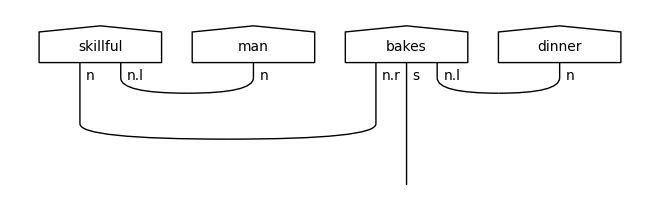

In [5]:
raw_train_diagrams[1].draw()

In [6]:
train_diagrams = [
    diagram.normal_form()
    for diagram in raw_train_diagrams if diagram is not None
]
val_diagrams = [
    diagram.normal_form()
    for diagram in raw_val_diagrams if diagram is not None
]

train_labels = [
    label for (diagram, label)
    in zip(raw_train_diagrams, train_labels)
    if diagram is not None]
val_labels = [
    label for (diagram, label)
    in zip(raw_val_diagrams, val_labels)
    if diagram is not None
]


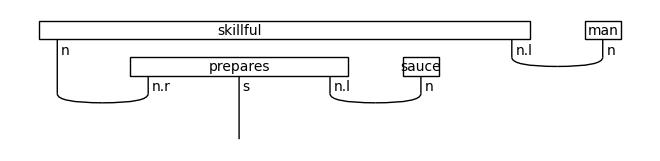

In [7]:
train_diagrams[0].draw()

In [8]:
from lambeq import AtomicType, IQPAnsatz, RemoveCupsRewriter

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)
remove_cups = RemoveCupsRewriter()

train_circuits = [ansatz(remove_cups(diagram)) for diagram in train_diagrams]
val_circuits =  [ansatz(remove_cups(diagram))  for diagram in val_diagrams]

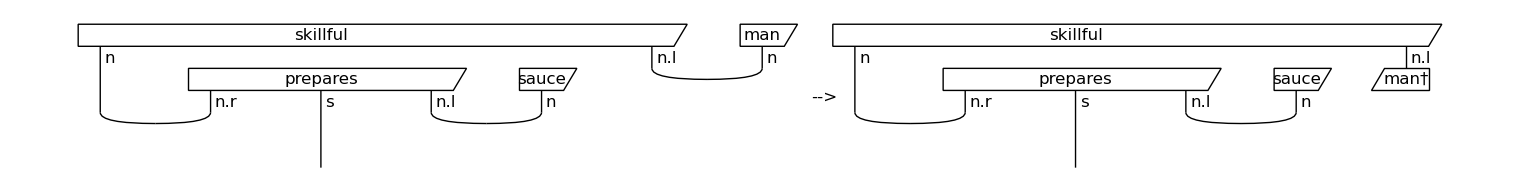

In [9]:
from lambeq.backend import draw_equation

original_diagram = train_diagrams[0]
removed_cups_diagram = remove_cups(original_diagram)

draw_equation(original_diagram, removed_cups_diagram, symbol='-->', figsize=(15, 6), asymmetry=0.3, fontsize=12)

36
Layer(left=Ty(), box=[CRz(skillful__n@n.l_0); Ty(qubit @ qubit) -> Ty(qubit @ qubit)], right=Ty())


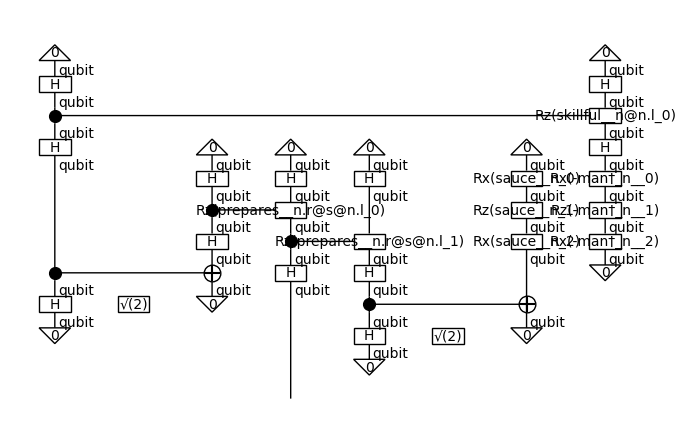

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [10]:
all_circuits = train_circuits + val_circuits

# print(all_circuits[0])
lrs = all_circuits[0].layers
# print(type(all_circuits[0].layers))

print(len(lrs))
print(lrs[4])

all_circuits[0].draw()

from discopy.quantum import Ket


In [11]:
from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel

all_circuits = train_circuits + val_circuits

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}

model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

In [12]:
from lambeq import BinaryCrossEntropyLoss

# Using the builtin binary cross-entropy error from lambeq
bce = BinaryCrossEntropyLoss()

acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
eval_metrics = {"acc": acc}

In [13]:
from lambeq import QuantumTrainer, SPSAOptimizer

trainer = QuantumTrainer(
    model,
    loss_function=bce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.001*EPOCHS},
    evaluate_functions=eval_metrics,
    evaluate_on_train=True,
    verbose = 'text',
    log_dir='RelPron/logs',
    seed=0
)

In [14]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(val_circuits, val_labels, shuffle=False)

# print(type(train_dataset), len(train_dataset), type(val_dataset), len(val_dataset))
# print(np.shape(train_dataset), np.shape(val_dataset))
# print(type(train_circuits), np.shape(train_circuits))
# print(type(train_circuits[0]))

In [15]:
trainer.fit(train_dataset, val_dataset)#, early_stopping_interval=10)

Epoch 1:    train/loss: 0.8570   valid/loss: 1.9404   train/acc: 0.6143   valid/acc: 0.6500
Epoch 2:    train/loss: 0.4640   valid/loss: 1.5179   train/acc: 0.5929   valid/acc: 0.4333
Epoch 3:    train/loss: 0.7529   valid/loss: 0.8197   train/acc: 0.6714   valid/acc: 0.5833
Epoch 4:    train/loss: 3.9352   valid/loss: 0.7302   train/acc: 0.4786   valid/acc: 0.5167
Epoch 5:    train/loss: 1.0367   valid/loss: 1.4661   train/acc: 0.4714   valid/acc: 0.5333
Epoch 6:    train/loss: 1.7974   valid/loss: 1.3739   train/acc: 0.4643   valid/acc: 0.6333
Epoch 7:    train/loss: 1.9866   valid/loss: 1.5744   train/acc: 0.5643   valid/acc: 0.3667
Epoch 8:    train/loss: 2.9699   valid/loss: 1.4959   train/acc: 0.5429   valid/acc: 0.4333
Epoch 9:    train/loss: 0.8021   valid/loss: 0.7389   train/acc: 0.4929   valid/acc: 0.6500
Epoch 10:   train/loss: 2.0271   valid/loss: 2.2276   train/acc: 0.4429   valid/acc: 0.4833
Epoch 11:   train/loss: 3.9491   valid/loss: 1.4452   train/acc: 0.5000   valid/

In [16]:
print(EPOCHS)
print(SEED)
print(BATCH_SIZE)

100
2
10


In [34]:
'''
Before we look at the results of the training, let us understand what exactly these circuits are that we trained above. 


We start by extracting the parameters for the symbols learned by Coecke et al. 


'''

# The symbols are the names of the respective parameters for the respective words
smbls = model.symbols

# And the weights are their respective values 
weights = model.weights

print('symbols: ', smbls)
# print('weights: ', weights)




# now, we are only interested in the noun weights 

newSmbls = []
newWeights = []

verbSmbls = []
verbWeights = []

adjSmbls = []
adjWeights = []

for i in range(len(weights)): 
    if '__n_' in str(smbls[i]) or '†_n__' in str(smbls[i]): # 
        newSmbls.append(smbls[i])
        newWeights.append(weights[i])
    elif '@s@' in str(smbls[i]): 
        verbSmbls.append(smbls[i])
        verbWeights.append(weights[i])
    elif 'n@n' in str(smbls[i]): 
        adjSmbls.append(smbls[i])
        adjWeights.append(weights[i])

# print('Symbols: ', newSmbls)
# # print('Weights: ', newWeights)

# print('Verb symbols: ', verbSmbls)
# # print('Verb weights: ', verbWeights)

# print(adjSmbls)


# create a simple dictionary for parameters and weights 
parameterDict = {}
for i in range(len(smbls)):
    parameterDict[str(smbls[i])] = weights[i].item()

print(parameterDict)

import pickle

with open('weightsDictTK.pkl', 'wb') as fp:
    pickle.dump(parameterDict, fp)




symbols:  [application__n_0, application__n_1, application__n_2, application†_n__0, application†_n__1, application†_n__2, bakes__n.r@s@n.l_0, bakes__n.r@s@n.l_1, cooks__n.r@s@n.l_0, cooks__n.r@s@n.l_1, dinner__n_0, dinner__n_1, dinner__n_2, dinner†_n__0, dinner†_n__1, dinner†_n__2, man†_n__0, man†_n__1, man†_n__2, meal__n_0, meal__n_1, meal__n_2, meal†_n__0, meal†_n__1, meal†_n__2, person†_n__0, person†_n__1, person†_n__2, prepares__n.r@s@n.l_0, prepares__n.r@s@n.l_1, program__n_0, program__n_1, program__n_2, program†_n__0, program†_n__1, program†_n__2, reads__n.r@s@n.l_0, reads__n.r@s@n.l_1, runs__n.r@s@n.l_0, runs__n.r@s@n.l_1, sauce__n_0, sauce__n_1, sauce__n_2, sauce†_n__0, sauce†_n__1, sauce†_n__2, skillful__n@n.l_0, software__n_0, software__n_1, software__n_2, software†_n__0, software†_n__1, software†_n__2, tasty__n@n.l_0, useful__n@n.l_0, woman†_n__0, woman†_n__1, woman†_n__2]
{'application__n_0': 0.5488135039273248, 'application__n_1': 0.7151893663724195, 'application__n_2': 0.

[0.5488135039273248, 0.7151893663724195, 0.6027633760716439]
[0.5743751631857914, 3.1253019985935704, 1.275731627281886]
[1.3186915343207763, -0.6937384869471458, 0.7535724565908977]
[2.299426374516049, 0.2557797918758361, 3.9875104207732766]
[1.4719027641317985, 0.7368539345629816, 1.155053696168279]
[0.8966046461683495, 1.9303348762539254, 0.9154241451131695]
[-2.1367838338357874, 0.1720884078928235, 1.3443115140069053]
[1.5682461704369162, 2.1936633117880473, -0.13705793711789127]
[1.6434348166810206, 2.2633382454610866, 0.7014720054335009]
[1.8094451318517448, -1.6248036359426372, 0.12385193381322379]
[-0.6224922544799282, -0.07770525823128224, -0.6342396525966958]
[-1.4194397360952515, 1.144769807924182, -0.2760134484422358]
[1.7786317960807008, 0.4259985660887437, -1.1151630556916918]
[1.7917898596238804, -2.2258581830231403, 2.0119899778618877]
[-0.07900417470954055, 2.6653357456734716, -0.644470870279822]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


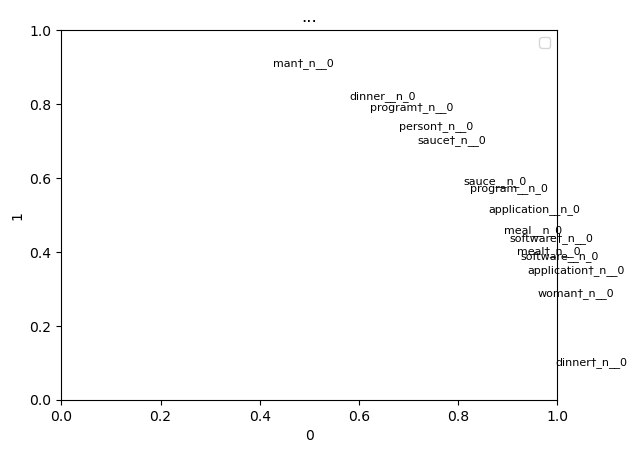

{'application__n_0': {'1': 0.25958, '0': 0.74042}, 'application†_n__0': {'1': 0.11832, '0': 0.88168}, 'dinner__n_0': {'1': 0.66245, '0': 0.33755}, 'dinner†_n__0': {'1': 0.00901, '0': 0.99099}, 'man†_n__0': {'0': 0.18264, '1': 0.81736}, 'meal__n_0': {'0': 0.7966, '1': 0.2034}, 'meal†_n__0': {'1': 0.15638, '0': 0.84362}, 'person†_n__0': {'0': 0.46279, '1': 0.53721}, 'program__n_0': {'1': 0.32079, '0': 0.67921}, 'program†_n__0': {'1': 0.61407, '0': 0.38593}, 'sauce__n_0': {'1': 0.34206, '0': 0.65794}, 'sauce†_n__0': {'1': 0.4845, '0': 0.5155}, 'software__n_0': {'1': 0.14449, '0': 0.85551}, 'software†_n__0': {'0': 0.81506, '1': 0.18494}, 'woman†_n__0': {'1': 0.07937, '0': 0.92063}}


In [33]:
'''
We want to see to what exact quantum states the respective nouns are mapped. We define a qiskit circuit consisting of a Rx, Rz, and Rx gate and we look at the quantum 
states that the respective nouns are mapped to. 
'''

from qiskit import QuantumCircuit, Aer, execute

def getProbDist(listOfParams): 

    # Create a quantum circuit with one qubit
    qc = QuantumCircuit(1, 1)

    # Initialize the qubit to the |0⟩ state
    initial_state = [1, 0]  # Coefficients for the |0⟩ state
    qc.initialize(initial_state, 0)

    # Apply Rx and Rz gates
    qc.rx(listOfParams[0], 0)
    qc.rz(listOfParams[1], 0) 
    qc.rx(listOfParams[2], 0)

    # Measure the qubit
    qc.measure(0, 0)  # Measure qubit 0 and store the result in classical bit 0

    # Draw the circuit (optional)
    # print("Quantum Circuit:")
    # print(qc.draw())

    # Use the Aer simulator to execute the circuit
    simulator = Aer.get_backend('qasm_simulator')
    shots = 100000  # Number of times to run the circuit
    job = execute(qc, simulator, shots=shots)  # Execute the circuit
    result = job.result()
    counts = result.get_counts(qc)

    # statevectors simulator 
    backend = Aer.get_backend('statevector_simulator')
    job = execute(qc, backend=backend, shots = 1, memory = True)
    stateVector = job.result().get_statevector(qc)

    # Calculate the probability distribution
    prob_dist = {state: counts[state] / shots for state in counts}

    return prob_dist, stateVector


# for plotting the Bloch spheres
from qiskit.visualization import plot_bloch_multivector

NounsAndVecs = {}

for i in range(0, len(newWeights), 3): 

    
        
    
    params = newWeights[i:i+3]
    print(params)

    if '†' in str(newSmbls[i]):
        params = [-x for x in params]
    #     print(params)

    probDist, nounState = getProbDist(params)

    NounsAndVecs[str(newSmbls[i])] = probDist

    plot_bloch_multivector(nounState, title=str(newSmbls[i]), filename = 'blochMultivectorTKet' + str(i) + '.png')

    
    plt.text(np.sqrt(probDist['0']), np.sqrt(probDist['1']), str(newSmbls[i]), fontsize = 8)


plt.title('...')
plt.ylabel('1')
plt.xlabel('0')
plt.legend()
plt.show()
print(NounsAndVecs)



In [19]:
'''
We see that there is *no* system whatsoever. 
This might be due to the poor training as we can see in the plots below. 

I could do an animation here. And with the loss function being minimized we see the vectors of the different words changing (hopefully in some intuitive way)

Later, we can use this 'proof' kind of idea to amplitude these things prior to the execution of the algorithm. 


NEXT STEP: INVESTIGATE THE VERBS AND RECONSTRUCT THE STATES THEY ARE MAPPED TO 

'''

"\nWe see that there is *no* system whatsoever. \nThis might be due to the poor training as we can see in the plots below. \n\nI could do an animation here. And with the loss function being minimized we see the vectors of the different words changing (hopefully in some intuitive way)\n\nLater, we can use this 'proof' kind of idea to amplitude these things prior to the execution of the algorithm. \n\n\nNEXT STEP: INVESTIGATE THE VERBS AND RECONSTRUCT THE STATES THEY ARE MAPPED TO \n\n"

In [20]:
def VerbCircuit(paramList, draw = False): 
    '''
    returns probability distribution over possible states
    '''

    # create quantum circuit with three qubits 
    qc = QuantumCircuit(3)

    # Initialize the qubit to the |0⟩ state
    initial_state = [1, 0]  # Coefficients for the |0⟩ state
    qc.initialize(initial_state, 0)
    qc.initialize(initial_state, 1)
    qc.initialize(initial_state, 2)

    qc.h(range(3))

    # add CNOT gates 
    qc.crz(paramList[0], 2, 1)
    qc.crz(paramList[1], 1, 0)

    qc.h(range(3))

    if draw: 
        print(qc)
    
    simulator = Aer.get_backend('statevector_simulator')

    # use this if you want the *complex* statevector!!
    # 
    # job = execute(qc, simulator)
    # result = job.result()
    # statevector = result.get_statevector()
    shots = 100000  # Number of times to run the circuit
    job = execute(qc, simulator, shots=shots)  # Execute the circuit
    result = job.result()
    counts = result.get_counts(qc)

    # Calculate the probability distribution
    prob_dist = {state: counts[state] / shots for state in counts}

    return prob_dist

print(VerbCircuit([1,2], draw= True))



     ┌─────────────────┐┌───┐         ┌───────┐┌───┐
q_0: ┤ Initialize(1,0) ├┤ H ├─────────┤ Rz(2) ├┤ H ├
     ├─────────────────┤├───┤┌───────┐└───┬───┘├───┤
q_1: ┤ Initialize(1,0) ├┤ H ├┤ Rz(1) ├────■────┤ H ├
     ├─────────────────┤├───┤└───┬───┘  ┌───┐  └───┘
q_2: ┤ Initialize(1,0) ├┤ H ├────■──────┤ H ├───────
     └─────────────────┘└───┘           └───┘       
{'000': 5.25780934030603e-06, '001': 1.66183287836071e-06, '010': 8.0643771242442e-07, '011': 1.66183287836071e-06, '100': 5.257933299646e-08, '101': 1.0835066732322e-07, '110': 3.4280652290523e-07, '111': 1.0835066732322e-07}


In [21]:
'''
Now, the same thing for adjectives
'''

def AdjectivesCircuit(paramList, draw = False): 
    '''
    returns probability distribution over possible states
    '''

    # create quantum circuit with three qubits 
    qc = QuantumCircuit(2)

    # Initialize the qubit to the |0⟩ state
    initial_state = [1, 0]  # Coefficients for the |0⟩ state
    qc.initialize(initial_state, 0)
    qc.initialize(initial_state, 1)

    qc.h(range(2))

    # add CNOT gates 
    qc.crz(paramList[0], 1, 0)

    qc.h(range(2))

    if draw: 
        print(qc)
    
    simulator = Aer.get_backend('statevector_simulator')

    # use this if you want the *complex* statevector!!
    # 
    # job = execute(qc, simulator)
    # result = job.result()
    # statevector = result.get_statevector()
    shots = 100000  # Number of times to run the circuit
    job = execute(qc, simulator, shots=shots)  # Execute the circuit
    result = job.result()
    counts = result.get_counts(qc)

    # Calculate the probability distribution
    prob_dist = {state: counts[state] / shots for state in counts}

    return prob_dist

print(AdjectivesCircuit([3.14], draw= True))



     ┌─────────────────┐┌───┐┌──────────┐┌───┐
q_0: ┤ Initialize(1,0) ├┤ H ├┤ Rz(3.14) ├┤ H ├
     ├─────────────────┤├───┤└────┬─────┘├───┤
q_1: ┤ Initialize(1,0) ├┤ H ├─────■──────┤ H ├
     └─────────────────┘└───┘            └───┘
{'00': 2.50398321889424e-06, '01': 2.49999841465942e-06, '10': 2.49601995178691e-06, '11': 2.49999841465942e-06}


Validation accuracy: 0.9333333333333333


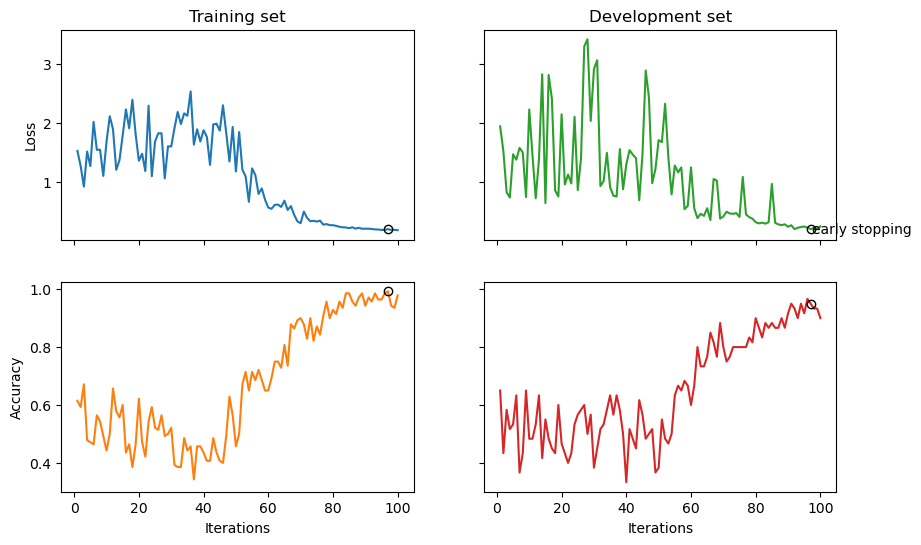

In [22]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, len(trainer.train_epoch_costs)+1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

# mark best model as circle
best_epoch = np.argmin(trainer.val_costs)
ax_tl.plot(best_epoch + 1, trainer.train_epoch_costs[best_epoch], 'o', color='black', fillstyle='none')
ax_tr.plot(best_epoch + 1, trainer.val_costs[best_epoch], 'o', color='black', fillstyle='none')
ax_bl.plot(best_epoch + 1, trainer.train_eval_results['acc'][best_epoch], 'o', color='black', fillstyle='none')
ax_br.plot(best_epoch + 1, trainer.val_eval_results['acc'][best_epoch], 'o', color='black', fillstyle='none')

ax_tr.text(best_epoch + 1.4, trainer.val_costs[best_epoch], 'early stopping', va='center')

# print test accuracy
model.load(trainer.log_dir + '/best_model.lt')
test_acc = acc(model(val_circuits), val_labels)
print('Validation accuracy:', test_acc.item())

In [23]:
'''
Now, we have a method to recreate the experiments done by Coecke et al. 

We now do exactly the same thing but we amplitude encode the nouns in there. 
This means: We do have the classical information of how close a cook, or a programmer are to 'food' or 'it'. 

Thus, we encode the nouns in two-dimensional vectorspaces, where the basis vectors correspond to FOOD and IT. 

In this case, we make it very easy and we set: 
Man                     = sqrt(0.5) |0> + sqrt(0.5) |1>
Cook = dinner = ...     = 1 |0>         + 0 |1>
Programmer = code = ... = 0 |0>         + 1 |1>

So ambiguous words are initialised by Hadamard gates and food related stuff is initialised as |0>, IT related stuff as |1>. 
 
'''

"\nNow, we have a method to recreate the experiments done by Coecke et al. \n\nWe now do exactly the same thing but we amplitude encode the nouns in there. \nThis means: We do have the classical information of how close a cook, or a programmer are to 'food' or 'it'. \n\nThus, we encode the nouns in two-dimensional vectorspaces, where the basis vectors correspond to FOOD and IT. \n\nIn this case, we make it very easy and we set: \nMan                     = sqrt(0.5) |0> + sqrt(0.5) |1>\nCook = dinner = ...     = 1 |0>         + 0 |1>\nProgrammer = code = ... = 0 |0>         + 1 |1>\n\nSo ambiguous words are initialised by Hadamard gates and food related stuff is initialised as |0>, IT related stuff as |1>. \n \n"

In [24]:
'''
We use the circuits defined above and add or subtract things from and to it using DisCoPy methods. 
'''


'\nWe use the circuits defined above and add or subtract things from and to it using DisCoPy methods. \n'